In [8]:
import pandas as pd 

from sklearn.linear_model import LinearRegression

from utils import create_time_series_splits

In [9]:
df = pd.read_csv('./preprocessed_data.csv', sep=',', parse_dates=['Datetime'], index_col=0)
df.index = pd.to_datetime(df['Datetime'], utc=True)
df.drop(columns=['Datetime'], inplace=True)
df.dropna(inplace=True)
to_remove = list(set(df.columns).difference({'Total Load', 'Most recent forecast','Day-ahead 6PM P10'}))

In [10]:
excluded_columns = ['Total Load', 'Most recent forecast', 'Most recent P10',
       'Most recent P90', 'Day-ahead 6PM forecast', 'Day-ahead 6PM P10',
       'Day-ahead 6PM P90', 'Week-ahead forecast', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'Season', 'Lockdown']

In [11]:
splits = create_time_series_splits(
    data=df,
    train_size_days=7*4, # 1 month for training (all times)
    test_size_days=7*4, # 1 month for testing (only at 6pm)
    num_splits=10,
    window_size_steps=4*6, # 6 hours window
    exclude_columns=excluded_columns,
    target_column='Total Load Interpolated',
    prediction_horizon_steps=4*30, # 30 hours step ahead forecast
    shifting_steps=1,
    elia_column_to_return='Day-ahead 6PM forecast',
    alignment_times=['18:00']
)

In [12]:
split_idx = 3
X_train = splits[split_idx]['X_train']
Y_train = splits[split_idx]['Y_train']
X_test = splits[split_idx]['X_test']
Y_test = splits[split_idx]['Y_test']
ELIA_train = splits[split_idx]['ELIA_train']
ELIA_test = splits[split_idx]['ELIA_test']

In [13]:
X_train.shape, Y_test.shape

((2688, 24), (28, 120))

In [14]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [15]:
Y_pred

array([[9988.4929792 , 9935.23480538, 9894.49381688, ..., 9122.00335606,
        9121.74252809, 9127.14969268],
       [9494.06421699, 9442.75865672, 9397.82416891, ..., 8978.66118614,
        8998.55288108, 9006.08292296],
       [8436.95728297, 8423.31402011, 8418.94208899, ..., 9415.75609971,
        9476.29352138, 9543.24111768],
       ...,
       [9355.83616931, 9299.37199165, 9243.62398507, ..., 8796.19667859,
        8821.97145509, 8850.39464165],
       [9528.80193135, 9451.81355938, 9394.85283033, ..., 8695.06928431,
        8718.22006261, 8734.9523654 ],
       [9484.19791153, 9395.65224671, 9310.42752538, ..., 8644.74350792,
        8669.6894119 , 8703.11103652]])

In [16]:
# column wise MAPE 
mape_linear = (abs(Y_pred - Y_test.values) / Y_test.values)

In [17]:
ELIA_test.columns = Y_test.columns

In [18]:
# column wise MAPE 
mape_elia = (abs(ELIA_test.values - Y_test.values) / Y_test.values)

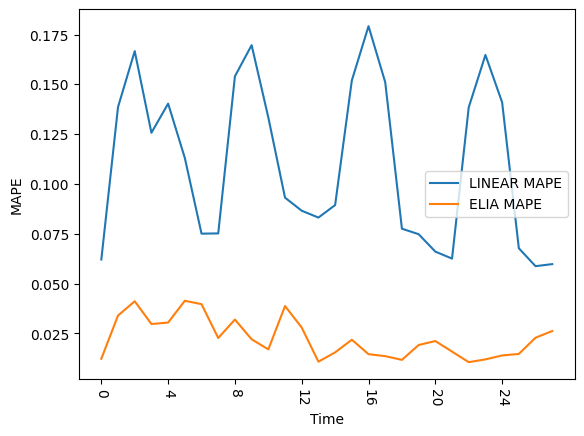

In [20]:
# plot mape 
import matplotlib.pyplot as plt
plt.plot(mape_linear.mean(axis=1), label='LINEAR MAPE')
plt.plot(mape_elia.mean(axis=1), label='ELIA MAPE')
plt.xlabel('Time')
plt.xticks(range(0, len(mape_linear.mean(axis=1)), 4))
plt.xticks(rotation=-90)
plt.ylabel('MAPE')
plt.legend()